In [3]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.tree import DecisionTreeClassifier
from sklearn.preprocessing import OneHotEncoder, MinMaxScaler, StandardScaler, PowerTransformer
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from scipy.sparse import hstack
from sklearn.compose import ColumnTransformer
import seaborn as sns
from sklearn.model_selection import GridSearchCV #for hypertuning
from sklearn.linear_model import LinearRegression,LogisticRegression, Lasso, Ridge
from lightgbm import LGBMRegressor


First let's analyze the dataset

In [7]:
#df = pd.read_csv('./archive/exams.csv')
df=pd.read_csv('exams.csv')
df

,gender,race/ethnicity,parental level of education,lunch,test preparation course,math score,reading score,writing score
0,female,group D,some college,standard,completed,59,70,78
1,male,group D,associate's degree,standard,none,96,93,87
2,female,group D,some college,free/reduced,none,57,76,77
3,male,group B,some college,free/reduced,none,70,70,63
4,female,group D,associate's degree,standard,none,83,85,86
...,...,...,...,...,...,...,...,...
995,male,group C,some college,standard,none,77,77,71
996,male,group C,some college,standard,none,80,66,66
997,female,group A,high school,standard,completed,67,86,86
998,male,group E,high school,standard,none,80,72,62


Here the dataset have categorical as well as numerical data. Categorical data includes race/ethinicity, parental level of education, lunch, test preparation course while numerical data includes math score, reading score, writing score.

In [8]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1000 entries, 0 to 999
Data columns (total 8 columns):
 #   Column                       Non-Null Count  Dtype 
---  ------                       --------------  ----- 
 0   gender                       1000 non-null   object
 1   race/ethnicity               1000 non-null   object
 2   parental level of education  1000 non-null   object
 3   lunch                        1000 non-null   object
 4   test preparation course      1000 non-null   object
 5   math score                   1000 non-null   int64 
 6   reading score                1000 non-null   int64 
 7   writing score                1000 non-null   int64 
dtypes: int64(3), object(5)
memory usage: 62.6+ KB


In [10]:
df.isna().any()

gender                         False
race/ethnicity                 False
parental level of education    False
lunch                          False
test preparation course        False
math score                     False
reading score                  False
writing score                  False
dtype: bool


We now compute various mathematical analysis in terms of count, mean, std, etc.

In [11]:
df.describe()

,math score,reading score,writing score
count,1000.000000,1000.000000,1000.000000
mean,67.810000,70.382000,69.140000
std,15.250196,14.107413,15.025917
min,15.000000,25.000000,15.000000
25%,58.000000,61.000000,59.000000
50%,68.000000,70.500000,70.000000
75%,79.250000,80.000000,80.000000
max,100.000000,100.000000,100.000000


Here we create a list of column indices where the data type of the column in a pandas DataFrame df is 'object'.

In [12]:
# Identify the categorical features
cat_cols = [col for col in df.columns if df[col].dtype=='O']
cat_cols

['gender',
 'race/ethnicity',
 'parental level of education',
 'lunch',
 'test preparation course']

Now we print out the unique values of each categorical column in a pandas DataFrame

In [13]:
for col in cat_cols:
    print(df[col].unique())

['female' 'male']
['group D' 'group B' 'group C' 'group E' 'group A']
['some college' "associate's degree" 'some high school'
 "bachelor's degree" "master's degree" 'high school']
['standard' 'free/reduced']
['completed' 'none']


To confirm that all the categorical columns in a pandas DataFrame can be converted to the categorical data type, you can check the number of unique values in each column and the percentage of unique values relative to the total number of values in the column. If the percentage of unique values is low (e.g., less than 50%), then it's likely that the column can be converted to the categorical data type without using too much memory. However, if the percentage of unique values is high (e.g., greater than 50%), then it may not be worth converting the column to the categorical data type, as the memory savings may be minimal.

In [14]:
# Get list of categorical columns
cat_cols = [col for col in df.columns if df[col].dtype == 'O']

# Loop over categorical columns
for col in cat_cols:
    unique_vals = df[col].nunique()
    total_vals = len(df[col])
    unique_pct = unique_vals / total_vals * 100
    print(f"{col}: {unique_vals} unique values ({unique_pct:.2f} of total)")


gender: 2 unique values (0.20 of total)
race/ethnicity: 5 unique values (0.50 of total)
parental level of education: 6 unique values (0.60 of total)
lunch: 2 unique values (0.20 of total)
test preparation course: 2 unique values (0.20 of total)



Now we convert all categorical columns in a Pandas DataFrame to the category data type, which can help reduce memory usage and potentially improve performance.

In [15]:
for col in cat_cols:
    df[col] = df[col].astype('category')
df.memory_usage(deep=True)


Index                           128
gender                         1232
race/ethnicity                 1492
parental level of education    1603
lunch                          1242
test preparation course        1235
math score                     8000
reading score                  8000
writing score                  8000
dtype: int64

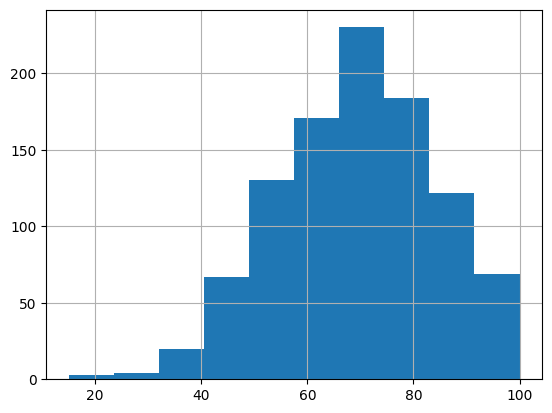

In [16]:
%matplotlib inline
# Creating Bar chart as the Target variable is Continuous
df['writing score'].hist();

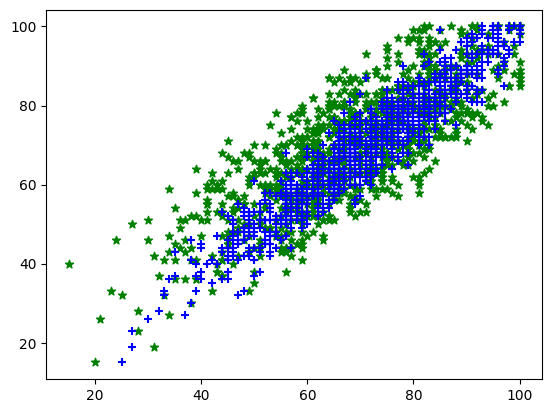

In [17]:
plt.scatter(df['math score'],df['writing score'],marker = '*', color = 'g')
plt.scatter(df['reading score'],df['writing score'],marker = '+', color = 'b')

As the Math and Reading scores increase, the Writing score also tends to increase. For this we calculate correaltion. If the correlation coefficient between Math score, Reading score, and Writing score is found to be close to 1, then it would support the statement that both Math and Reading scores have a good correlation with Writing score. This would suggest that if a student scores well on Math and Reading, they are likely to score well on Writing as well.

In [18]:
CorrelationData=df[['math score','reading score','writing score']].corr()
CorrelationData

,math score,reading score,writing score
math score,1.000000,0.811767,0.790055
reading score,0.811767,1.000000,0.948909
writing score,0.790055,0.948909,1.000000


In [19]:
final_cols = ['gender', 'race/ethnicity','parental level of education','lunch', 'test preparation course', 'math score','reading score']

df_final = df[final_cols]
X = df_final[final_cols]
y = df['writing score']
X
y

0      78
1      87
2      77
3      63
4      86
       ..
995    71
996    66
997    86
998    62
999    45
Name: writing score, Length: 1000, dtype: int64

In [20]:
num_cols = ['math score', 'reading score']


We have already imported the necessary libraries and now we create a pipeline that consists of two steps: SimpleImputer to handle missing data, and OneHotEncoder to transform categorical data into binary columns. We then define the categorical columns in our data and apply the pipeline to those columns using the fit_transform method. Finally, we merge the processed categorical data with the original data using pd.concat. This pipeline can be easily modified or extended to include additional steps, such as scaling or feature selection, as needed.

In [21]:
# Create a pipeline for categorical data
categorical_pipeline = Pipeline([
    ('imputer', SimpleImputer(strategy='most_frequent')),
    ('encoder', OneHotEncoder(handle_unknown='ignore'))
])
categorical_cols = ['gender',
 'race/ethnicity',
 'parental level of education',
 'lunch',
 'test preparation course']

 # Apply the pipeline to the categorical columns
categorical_df = categorical_pipeline.fit_transform(df[categorical_cols])

# Convert the sparse matrix to a Pandas DataFrame
categorical_df = pd.DataFrame(categorical_df.toarray())

# Concatenate the categorical data with the original DataFrame
df = pd.concat([df.drop(categorical_cols, axis=1), categorical_df], axis=1)

Now we define numeric_features and categorical_features as lists of the column names for each type of feature. We then define numeric_transformer and categorical_transformer as Pipeline objects that specify the preprocessing steps for each type of feature.

Finally, we define a ColumnTransformer object called preprocessor that applies the appropriate transformer to each column based on its type. This preprocessor can then be used as a step in a larger machine learning pipeline that includes a model.

In [22]:

# define the preprocessing pipelines for numerical and categorical features
num_cols = ['math score', 'reading score']
numeric_transformer = Pipeline(steps=[
    ('scaler', StandardScaler())])

categorical_cols = ['gender',
 'race/ethnicity',
 'parental level of education',
 'lunch',
 'test preparation course']

categorical_transformer = Pipeline(steps=[
    ('onehot', OneHotEncoder())])


In [23]:
# convert all column names to strings
df.columns = df.columns.astype(str)
df


,math score,reading score,writing score,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16
0,59,70,78,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,1.0,0.0
1,96,93,87,0.0,1.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0
2,57,76,77,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,1.0
3,70,70,63,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,1.0
4,83,85,86,1.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
995,77,77,71,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,1.0
996,80,66,66,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,1.0
997,67,86,86,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0
998,80,72,62,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0


In [24]:
num_pipeline = Pipeline([
    ('num_smoothening',PowerTransformer())
])

# define the column transformer to preprocess both numeric and categorical features
preprocessor = ColumnTransformer(
    transformers=[
        ('num', numeric_transformer, num_cols),
        ('cat', categorical_transformer, categorical_cols)])


In [25]:
from sklearn.model_selection import train_test_split
X_train, X_test , y_train, y_test = train_test_split(X,y, test_size=0.2, random_state = 42)

# check the shapes of the training and test data
print(f'X_train shape: {X_train.shape}')
print(f'y_train shape: {y_train.shape}')
print(f'X_test shape: {X_test.shape}')
print(f'y_test shape: {y_test.shape}')
X_train

X_train shape: (800, 7)
y_train shape: (800,)
X_test shape: (200, 7)
y_test shape: (200,)


,gender,race/ethnicity,parental level of education,lunch,test preparation course,math score,reading score
29,male,group D,associate's degree,standard,none,90,87
535,male,group B,some high school,free/reduced,completed,58,56
695,female,group D,some high school,standard,completed,69,86
557,female,group E,associate's degree,free/reduced,none,60,74
836,female,group A,master's degree,standard,completed,68,76
...,...,...,...,...,...,...,...
106,female,group B,some high school,standard,completed,69,76
270,female,group C,some college,standard,none,84,88
860,male,group B,associate's degree,standard,completed,79,77
435,female,group C,associate's degree,standard,completed,71,84


In [26]:
# define the final pipeline that includes the column transformer and a logistic regression model
pipe = Pipeline(steps=[('preprocessor', preprocessor),
                       ('classifier', LinearRegression())])



In [27]:
# fit the pipeline to the training data
pipe.fit(X_train, y_train)

# evaluate the pipeline on the test data
score = pipe.score(X_test, y_test)
print(f'Test score: {score:.2f}')

Test score: 0.94
